In [1]:
import csv
import os
from functools import partial
import json
from datetime import datetime
import pickle
import numpy as np
import pandas as pd
import scipy.stats as st
import geopandas as gpd
import matplotlib.pyplot as plt

import gerrychain
import maup

from gerrychain import (
    Election,
    Graph,
    MarkovChain,
    Partition,
    accept,
    constraints,
    updaters,
    tree,
)

from gerrychain.metrics import efficiency_gap, mean_median
from gerrychain.proposals import recom
from gerrychain.tree import recursive_tree_part
from gerrychain.updaters import cut_edges

pd.set_option('display.max_columns', None)

import warnings

warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
warnings.filterwarnings('ignore', 'ignoring nan encountered at node', UserWarning)

In [111]:
# construct graph if needed
print("({}) Started.".format(datetime.now()))
graph = Graph.from_file('./data/oh_blocks.shp')
print("({}) Finished.".format(datetime.now()))

(2021-04-28 22:51:47.004478) Started.


C:\Users\epicp\Anaconda3\lib\site-packages\gerrychain\graph\graph.py:272: UserWarning: NA values found in column SUFFIX!
  warnings.warn("NA values found in column {}!".format(column))
C:\Users\epicp\Anaconda3\lib\site-packages\gerrychain\graph\graph.py:272: UserWarning: NA values found in column TABBLKSUFX!
  warnings.warn("NA values found in column {}!".format(column))
C:\Users\epicp\Anaconda3\lib\site-packages\gerrychain\graph\graph.py:272: UserWarning: NA values found in column PRECODE!
  warnings.warn("NA values found in column {}!".format(column))
C:\Users\epicp\Anaconda3\lib\site-packages\gerrychain\graph\graph.py:272: UserWarning: NA values found in column TOTREG16!
  warnings.warn("NA values found in column {}!".format(column))
C:\Users\epicp\Anaconda3\lib\site-packages\gerrychain\graph\graph.py:272: UserWarning: NA values found in column TOTVOTE16!
  warnings.warn("NA values found in column {}!".format(column))
C:\Users\epicp\Anaconda3\lib\site-packages\gerrychain\graph\graph

(2021-04-29 01:24:04.048533) Finished.


In [113]:
print("({}) Started.".format(datetime.now()))
with open('./data/oh_blocks_graph.pkl', 'wb') as f:
    pickle.dump(graph, f)
print("({}) Finished.".format(datetime.now()))

(2021-04-29 01:25:38.472896) Started.
(2021-04-29 01:26:33.618649) Finished.


## Load graph and initial `Partition`

In [177]:
# initial_plan_path = './data/stsend-2011.geojson'
# initial_plan_path = None # set to None to randomly generate an initial Partition using recursive_tree_part

ensemble_output_path = './data/sth_1500step_nopacking_opportunity.pkl'

In [2]:
# This is a shapefile with block-level demographic and past election data.
shapefile_path = './data/oh_blocks.shp'

# This is a pickle of a GerryChain Graph corresponding to the above shapefile
# which we import directly to save the time needed to build the graph.
graph_path = './data/oh_blocks_graph.pkl'

In [3]:
print("({}) Started.".format(datetime.now()))

with open(graph_path, 'rb') as f:
    graph = pickle.load(f)
    
gdf = gpd.read_file(shapefile_path)
    
print("({}) Finished.".format(datetime.now()))

(2021-05-13 20:24:05.393810) Started.
(2021-05-13 20:26:16.256346) Finished.


In [12]:
dist_pop = [gdf[gdf['HDIST'] == dist].sum()['tot'] for dist in gdf['HDIST'].unique()]

In [13]:
print(np.min(dist_pop))
print(np.max(dist_pop))

106331.0
125488.0


In [14]:
print(dist_pop)

[122270.0, 106331.0, 114734.0, 119717.0, 110734.0, 110998.0, 120653.0, 121707.0, 115215.0, 110748.0, 122295.0, 121925.0, 120050.0, 113763.0, 117117.0, 118753.0, 120270.0, 110857.0, 111329.0, 119185.0, 112374.0, 111782.0, 122159.0, 122263.0, 107841.0, 120531.0, 111843.0, 117361.0, 121423.0, 121328.0, 113359.0, 112243.0, 118664.0, 116912.0, 118049.0, 111538.0, 116431.0, 112814.0, 121751.0, 116821.0, 118314.0, 118512.0, 115070.0, 121563.0, 117123.0, 121028.0, 111379.0, 116994.0, 111743.0, 115264.0, 119807.0, 112089.0, 119804.0, 118183.0, 115587.0, 120871.0, 115760.0, 117754.0, 112804.0, 111207.0, 111836.0, 120564.0, 111807.0, 119780.0, 114376.0, 112906.0, 122139.0, 122245.0, 112565.0, 117476.0, 118924.0, 120257.0, 118475.0, 115150.0, 119548.0, 119850.0, 121674.0, 117149.0, 112079.0, 118563.0, 111331.0, 112126.0, 119104.0, 117848.0, 116969.0, 113794.0, 118140.0, 124475.0, 112214.0, 120509.0, 111558.0, 111800.0, 115515.0, 117214.0, 116920.0, 111637.0, 110985.0, 114520.0, 125488.0]


In [117]:
election_names = ["PRES16", "SEN16", "USH16", "SSEN16", "STH16"]
election_columns = [
    ["PRES16D", "PRES16R"],
    ["SEN16D", "SEN16R"],
    ["USH16D", "USH16R"],
    ["SSEN16D", "SSEN16R"],
    ["STH16D", "STH16R"],
]

for x in election_columns:
    for i in range(len(graph.nodes)):
        if np.isnan(graph.nodes[i][x[0]]):
            graph.nodes[i][x[0]] = 0
        if np.isnan(graph.nodes[i][x[1]]):
            graph.nodes[i][x[1]] = 0

(2021-04-30 10:01:17.835552) Started.
(2021-04-30 10:03:42.579547) Finished.


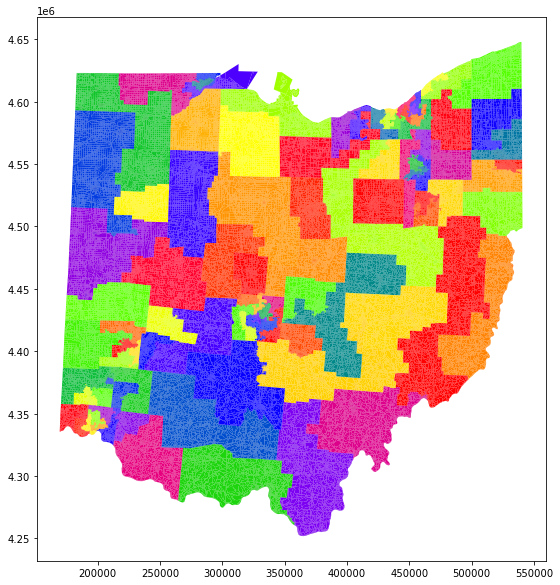

In [166]:
print("({}) Started.".format(datetime.now()))

if initial_plan_path is None:
    pass
    # Generate initial plan using recursive_tree_part
    
    
    # ...TODO

else:
    # Populate graph with initial plan
#     initial_gdf = gpd.read_file(initial_plan_path)
    assignment = 'HDIST'

#     gdf.to_crs(initial_gdf.crs, inplace=True)

#     assignment = maup.assign(gdf, initial_gdf)
#     gdf['assignment'] = assignment

#     graph.join(gdf, columns=["assignment"], left_index="GEOID", right_index="GEOID")
    
    num_districts = gdf[assignment].nunique()
    ideal_population = sum(gdf["tot"].fillna(0.0)) / num_districts

    # Configure partition updaters
    def election_results_dict(partition, election_name):
        return {
            'wins': partition[election_name].wins("Democratic"),
            'percents': partition[election_name].percents("Democratic"),
            'mean_median': partition[election_name].mean_median(),
            'mean_thirdian': partition[election_name].mean_thirdian(),
            'efficiency_gap': partition[election_name].efficiency_gap(),
            'partisan_bias': partition[election_name].partisan_bias(),
            'partisan_gini': partition[election_name].partisan_gini(),
        }

    def num_co_splits(partition):
        return sum([len(partition['num_county_splits'][key].contains) for key in partition['num_county_splits']])

    def process_partition(partition):
        return {
                'num_county_splits': num_co_splits(partition),
                'totVAP': partition['totVAP'],
                'WVAP': partition['WVAP'],
                'BVAP': partition['BVAP'],
                'AVAP': partition['AVAP'],
                'NatVAP': partition['NatVAP'],
                'HVAP': partition['HVAP'],
                'PRES16': election_results_dict(partition, 'PRES16'),
                'SEN16': election_results_dict(partition, 'SEN16'),
                'USH16': election_results_dict(partition, 'USH16'),
                'SSEN16': election_results_dict(partition, 'SSEN16'),
                'STH16': election_results_dict(partition, 'STH16'),
            }

    vap_columns = ['totVAP', 'WVAP', 'BVAP', 'AVAP', 'NatVAP', 'HVAP']

    pop_col = "tot"
#     district_col = "HDIST"
    county_col = "COUNTY"

    elections = [
        Election(
            election_names[i],
            {"Democratic" : election_columns[i][0], "Republican" : election_columns[i][1]},
        )
        for i in range(len(election_columns))
    ]

    my_updaters = {
        "population": updaters.Tally(pop_col, alias="population"),
        "cut_edges": cut_edges,
        "num_county_splits": updaters.county_splits("num_county_splits", county_field_name=county_col),
    }

    vap_updaters = {vap_column : updaters.Tally(vap_column) for vap_column in vap_columns}
    my_updaters.update(vap_updaters)

    election_updaters = {election.name : election for election in elections}
    my_updaters.update(election_updaters)

    # Initialize Partition object and display initial plan
    initial_partition = Partition(graph, assignment=assignment, updaters=my_updaters)
    initial_partition.plot(gdf, figsize=(10, 10), cmap="prism")

print("({}) Finished.".format(datetime.now()))

## Define chain constraints and length

In [184]:
proposal = partial(
    recom, pop_col=pop_col, pop_target=ideal_population, epsilon=0.02, node_repeats=2
)

# upper-bound the number of cut edges by k times the number of cut edges of the initial partition
k = 1.00001
compactness_bound = constraints.UpperBound(
    lambda p: len(p["cut_edges"]), 
    k * len(initial_partition["cut_edges"])
)

# upper-bound the number of county splits by k times the number of splits in the initial partition
k = 1.001

def num_co_splits(partition):
    return sum([len(partition['num_county_splits'][key].contains) - 1 for key in partition['num_county_splits']])

co_split_bound = constraints.UpperBound(
    num_co_splits,
    k * num_co_splits(initial_partition)
)

# bound the number of Democratic-won districts by lower_bound and upper_bound
election = 'PRES16'
lower_bound = 33
upper_bound = 50

def dem_wins(partition):
    return partition[election].wins("Democratic")

dem_win_lower_bound = constraints.LowerBound(dem_wins, lower_bound)
dem_win_upper_bound = constraints.UpperBound(dem_wins, upper_bound)

# lower-bound the number of 37%-55% BVAP districts by the number of these districts in the initial partition
def num_bvap_districts(partition):
    pct_bvap = np.array(list(partition['BVAP'].values())) / np.array(list(partition['totVAP'].values()))
    df = pd.DataFrame({'BVAP': pct_bvap, 'PRES16': list(partition['PRES16'].percents('Democratic'))})
    cond = (0.37 <= df['BVAP']) & (df['BVAP'] < 0.55) & (df['PRES16'] >= 0.5)
    return cond.sum()

bvap_bound = constraints.SelfConfiguringLowerBound(num_bvap_districts)

# lower-bound the number of 37%-50% BVAP districts by the number of these districts in the initial partition
def num_37_50_bvap_districts(partition):
    pct_bvap = np.array(list(partition['BVAP'].values())) / np.array(list(partition['totVAP'].values()))
    df = pd.DataFrame({'BVAP': pct_bvap, 'PRES16': list(partition['PRES16'].percents('Democratic'))})
    cond = (0.37 <= df['BVAP']) & (df['BVAP'] < 0.5) & (df['PRES16'] >= 0.5)
    return cond.sum()

bvap_37_50_bound = constraints.SelfConfiguringLowerBound(num_37_50_bvap_districts)

# lower-bound the number of VRA districts (note that VRA in the file naming conventions refers to the 37-55 condition above)
def num_50plus_bvap_districts(partition):
    pct_bvap = np.array(list(partition['BVAP'].values())) / np.array(list(partition['totVAP'].values()))
    df = pd.DataFrame({'BVAP': pct_bvap, 'PRES16': list(partition['PRES16'].percents('Democratic'))})
    cond = (df['BVAP'] > 0.5) & (df['PRES16'] >= 0.5)
    return cond.sum()

vra_bound = constraints.SelfConfiguringLowerBound(num_50plus_bvap_districts)

def num_37plus_bvap_districts(partition):
    pct_bvap = np.array(list(partition['BVAP'].values())) / np.array(list(partition['totVAP'].values()))
    df = pd.DataFrame({'BVAP': pct_bvap, 'PRES16': list(partition['PRES16'].percents('Democratic'))})
    cond = (df['BVAP'] > 0.37) & (df['PRES16'] >= 0.5)
    return cond.sum()

opportunity_bound = constraints.SelfConfiguringLowerBound(num_37plus_bvap_districts)

# upper-bound the % BVAP of all districts
def max_bvap(partition):
    pct_bvap = np.array(list(partition['BVAP'].values())) / np.array(list(partition['totVAP'].values()))
    return np.max(pct_bvap)

max_bvap_bound = constraints.SelfConfiguringUpperBound(max_bvap)

chain = MarkovChain(
    proposal=proposal,
    constraints=[
        constraints.within_percent_of_ideal_population(initial_partition, 0.09),
        compactness_bound,
        co_split_bound,
#         dem_win_lower_bound,
#         dem_win_upper_bound,
#         bvap_bound,
#         bvap_37_50_bound,
#         vra_bound,
        max_bvap_bound,
        opportunity_bound,
        constraints.no_more_discontiguous,
    ],
    accept=accept.always_accept,
    initial_state=initial_partition,
    total_steps=1500,
)

## Run, process, and save chain

(2021-05-01 05:28:29.625082) Chain execution started.
(2021-05-01 05:28:29.858572) 1 steps completed.
(2021-05-01 05:28:45.412694) 2 steps completed.
(2021-05-01 05:28:51.761580) 3 steps completed.
(2021-05-01 05:28:56.932612) 4 steps completed.
(2021-05-01 05:29:08.013731) 5 steps completed.
(2021-05-01 05:31:51.650600) 6 steps completed.
(2021-05-01 05:31:59.654661) 7 steps completed.
(2021-05-01 05:32:07.141543) 8 steps completed.
(2021-05-01 05:32:12.721560) 9 steps completed.
(2021-05-01 05:32:43.193257) 10 steps completed.
(2021-05-01 05:32:56.381523) 11 steps completed.
(2021-05-01 05:33:16.453287) 12 steps completed.
(2021-05-01 05:33:21.915257) 13 steps completed.
(2021-05-01 05:33:30.816588) 14 steps completed.
(2021-05-01 05:33:35.637878) 15 steps completed.
(2021-05-01 05:33:40.071195) 16 steps completed.
(2021-05-01 05:33:51.553130) 17 steps completed.
(2021-05-01 05:34:06.474726) 18 steps completed.
(2021-05-01 05:34:26.072648) 19 steps completed.
(2021-05-01 05:34:31.862

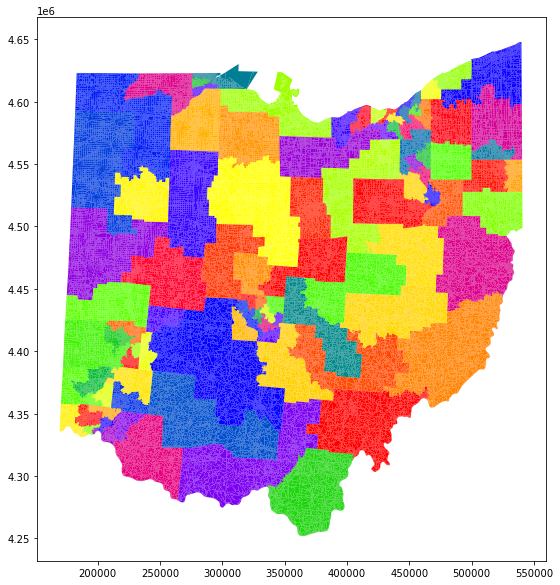

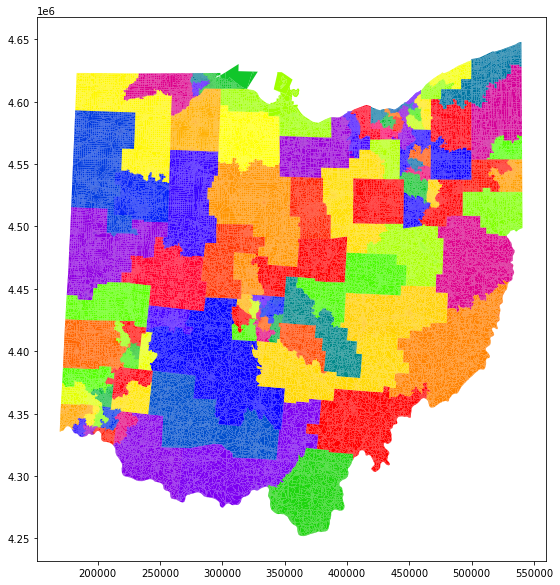

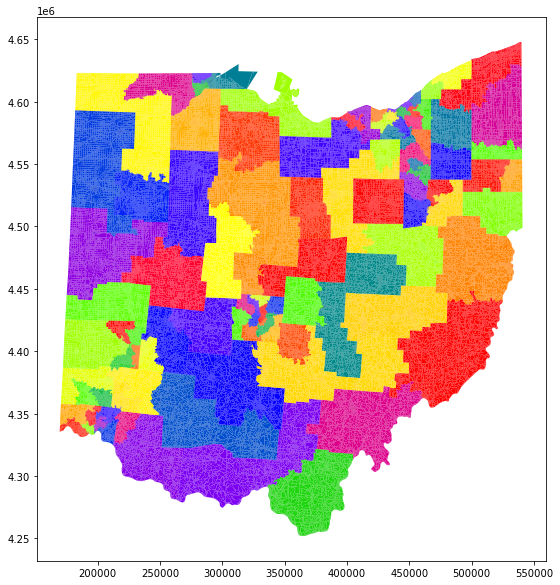

In [187]:
print("({}) Chain execution started.".format(datetime.now()))

generated_chain = []
i = 0
for partition in chain:
    d = {key: partition[key] for key in my_updaters.keys()}
#     if i % 10 == 0:
#         d['assignment'] = {i: partition.assignment[i] for i in list(graph.nodes)} # MEMORY INTENSIVE!!!
    generated_chain.append(d)
    i += 1
    if i < 25 or i % 25 == 0:
        print("({}) {} steps completed.".format(datetime.now(), i))
    if i % 500 == 0:
        partition.plot(gdf, figsize=(10, 10), cmap="prism")
    
print("({}) Chain execution finished.".format(datetime.now()))

In [188]:
processed_chain = []
for i in range(len(generated_chain)):
    processed_chain.append(
        {
            'num_county_splits': num_co_splits(generated_chain[i]),
            'num_cut_edges': len(generated_chain[i]['cut_edges']),
#             'assignment': generated_chain[i]['assignment'],
            'totVAP': generated_chain[i]['totVAP'],
            'WVAP': generated_chain[i]['WVAP'],
            'BVAP': generated_chain[i]['BVAP'],
            'AVAP': generated_chain[i]['AVAP'],
            'NatVAP': generated_chain[i]['NatVAP'],
            'HVAP': generated_chain[i]['HVAP'],
            'PRES16': election_results_dict(generated_chain[i], 'PRES16'),
            'SEN16': election_results_dict(generated_chain[i], 'SEN16'),
            'USH16': election_results_dict(generated_chain[i], 'USH16'),
            'SSEN16': election_results_dict(generated_chain[i], 'SSEN16'),
            'STH16': election_results_dict(generated_chain[i], 'STH16'),
        }
    )

In [189]:
ensemble_output_path

'./data/sth_1500step_nopacking_opportunity.pkl'

In [190]:
print("({}) Saving chain...".format(datetime.now()))

with open(ensemble_output_path, 'wb') as f:
    pickle.dump(processed_chain, f)
    
print("({}) Chain saved.".format(datetime.now()))

(2021-05-01 11:29:29.299622) Saving chain...
(2021-05-01 11:29:30.746590) Chain saved.
